# Ising models and Metropolis algorithm

In [2]:
import matplotlib.pyplot as plt
import ipywidgets as widgets

import numpy as np

- Ising models are a class of simple lattice based spin $s = \pm 1$ ssytems which are widely used for studying the nature of phase transitions.

- Many aspects of phase transitions are universal and independent of mciroscopic details of interactions. Hence One wants as simple of a model capable of displaying phase transition as possible! Ising models fit the bill perfectly and one could even obtain analytical solutions (1D and 2D).

- Ising Models are defined by hamiltonian which encodes interactions between spins $i$ and $j$ (nearest enighbours $|i-j|=1$) and interactions of spins with an external field $B$

$$\boxed{H([s])= \sum_{\langle ij \rangle} J_{ij}s_i s_j - \mu B \sum_i s_i}$$

- Partition function is sum over all posisble microstates or in the case of Ising models over all possible spin configurations!

$$\boxed{Z=\sum_{[s]}e^{-H([s])/k_B T}}$$

- Note that the spin lattice in Ising models could be in 1D, 2D, 3D, ... ND dimensions. In this notebook we only look at 2D becuase it is the simplest system that can display phase-transition and plus is faster to simulate and visualize

### Thermodynamics of Ising models

#### Magnetization

- **Total magnetization, $M$**  

$$M([s])=\sum_is_i $$

- **Magnetization per spin $m$** 

$$m([s])=\frac{1}{N}\sum_is_i =\frac{M}{N}$$

#### Heat capacity $C_v$

$$ C_V(T) = \Big (\frac{\partial E}{\partial T} \Big )_V= \frac{1}{k_B T^2} \big(\langle E^2 \rangle-\langle E \rangle^2 \big) $$

#### Susceptibility $\chi$

$$\chi_T=\Big (\frac{\partial M}{\partial B} \Big )_T= \frac{1}{k_B T} \big(\langle M^2 \rangle-\langle M \rangle^2 \big) $$

### Free energy profile

$$Z(M) = \sum_{[s]} e^{-\beta H([s])} \delta (M-M([s]))$$

$$F(M)=-\beta^{-1} log Z(M)$$

Note that $Z(M)$ is a partial sum over states for which magnetization is equal to a particular value $M$ as opposed to the full partition function $Z$ where summation is unrestricted.

### Numerical calculation of thermodynamic quantities

[[ 1 -1  1 -1 -1  1 -1  1]
 [ 1  1 -1 -1  1 -1 -1 -1]
 [ 1 -1 -1 -1  1  1  1 -1]
 [-1 -1  1  1 -1  1  1 -1]
 [-1 -1 -1 -1  1 -1  1  1]
 [ 1  1 -1  1 -1  1 -1 -1]
 [ 1  1 -1  1  1 -1 -1 -1]
 [-1 -1  1 -1 -1 -1 -1  1]]


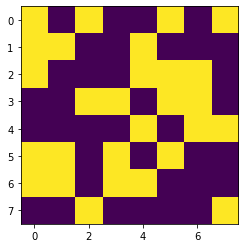

In [3]:
spins = np.random.choice([-1,1],size=(8,8))

print(spins)

plt.imshow(spins)

### Enforcing periodic boundary conditions

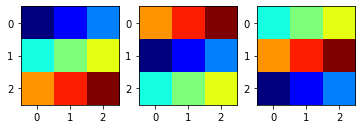

In [4]:
X = np.array([[1, 2 ,3], 
              [4, 5, 6],
              [7, 8, 9]])
Y = np.roll(X, 1, axis=0)
Z = np.roll(X, -1, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
ax1.imshow(X, cmap='jet')
ax2.imshow(Y, cmap='jet')
ax3.imshow(Z, cmap='jet')

In [31]:
def get_E(spins, J=1, B=0):
    '''Compute energy of spin lattice by lopping over each spin 
    with periodic boundary conditions enforced 
    via numpy roll''' 
      
    z = np.roll(spins, 1, axis = 0) + np.roll(spins, -1, axis = 0) + \
        np.roll(spins, 1, axis = 1) + np.roll(spins, -1, axis = 1)

    E = np.sum( -J*spins*z/4 )
    
    return E - B*np.sum(spins)

def get_E2(spins,N,J,B):   
     
    N =len(spins)
    E = 0
    for i in range(N):
        for j in range(N):   
            z = spins[(i+1)%N, j] + spins[(i-1)%N, j] +\
                spins[i,(j+1)%N]  +  spins[i,(j-1)%N]
            E += -J*z*spins[i,j]/4 
            
    return E - B*np.sum(spins) 


def get_dE(spins, i, j, J=1, B=0):
    '''Compute change in energy of 2D spin lattice 
    after flipping a spin at a location (i,j''' 
    
    N = len(spins)
    
    z  = spins[(i+1)%N, j] + spins[(i-1)%N, j] + \
             spins[i, (j+1)%N] + spins[i, (j-1)%N] 
             
    dE = 2*spins[i,j]*(J*z + B)
    
    return dE
        

In [38]:
#get_E(spins)
#get_dE(spins, 1, 2)

### Sampling of Boltzmann distribution: MC vs MCMC

**MC sampling**
- How to compute the expectation value of a thermodynamic variable $A$. In theory everything is simple: we need to sample from the exponential distribution.

$$P(E_i)= \frac{e^{-\beta E_i}}{\sum_i e^{-\beta E_i}}$$

$$\langle A\rangle = \sum_i A_iP(E_i) \approx\frac{1}{N}\sum_{i=1}^N \underbrace{A_i}_{{\rm chosen}\ {\rm acc.}\ {\rm to}\ P(E_i)}$$

- In practice the brute force MC sampling of exponential fails for even smallest ising lattices. 

**Problems with MC**
- There is an astronomical number of states, $i = 1... N^2$! 
- Most of these microstates make exponentially small contribution to probability distribution! $P(E_i)$
- Brute force MC will not be efficient for sampling important portions of $P(E_i)$.
- **Conclusion: We need Importance sampling!**

**MCMC Sampling**

-  Instead of ranodmly picking states we generate chain of states. This sampling technique is known as Markov Chain Monte Carlo (MCMC). MCMC generates random walks in configuration space and is more efficient at finding sampling states than basic MC.



### Generating chains! Master Equation and Detailed Balance

**Random chain**

- In simple MC each sampled state $X_i$ at steo $i$ is independet of the next or previous steps. 

- Thus, MC sampling generates totally uncorrelated samples which is good for rapid convergence according to Central Limit Theorem. But as we remarked above the samples are most likely not covering important areas!

$$P(X_N, ..., X_2, X_1) = P_N(X_N)\cdot ... P_2(X_2) \cdot P_1(X_1)$$

**Markov chain:**

- In simple MCMC each sampled state $X_i$ at steo $i$ is generated from $i-1$.
- This introduces correlations between samples which means slower covnergence to the mean.
- On the other hand MCMC find the important areas for sampling much faster so in the hand it wins big compared to MC.

$$P(X_N, ..., X_2, X_1) = P_N(X_N)\cdot ... P_3(X_3| X_2) \cdot P_2(X_2| X_1)... P_1(X_1)$$


- The probability of picking state $i+1$ given taht we started from $i$ is referred to as **transition probability** $T_{ij}$ 

$$T(X_2 \leftarrow X_1) = T_{21} = P(X_2|X_1)$$

- As any probability it should be normalized meaning summing over all possible states should yield one:

$$\sum_{X} T(X\leftarrow X') = 1$$

**Probability of being at $X$ at $t+\Delta t$ given a prior state at $(X',t)$**

$$P(X, t+\Delta t) = \sum_{X'}  T(X \leftarrow X') P(X', t)$$

- Subtracting P(X,t) from both states we can obtain equation of motion for Markov chain.

$$P(X, t+\Delta t) -P(X,t)= \sum_{X'}  T(X \leftarrow X') P(X', t) - P(X, t)\sum_{X'} T(X'\leftarrow X)$$

**Master equation: A continuity equation in probability space.**

$$\boxed{\frac{\partial P(X,t)}{\partial t} = \sum_{X'}  w_{X X'} P(X', t) - \sum_{X'} w_{X' X} P(X, t)}$$

- Where we have defined transition rates as: $w(X' \rightarrow X, t) = lim_{\Delta t \rightarrow 0}\frac{T(X' \rightarrow X, t)}{\Delta t}$

### Detailed Balance = Equilibrium

<br>

$$\boxed{\frac{\partial P(X,t)}{\partial t}  = \sum_{X'} P(X', t) w_{X'X} - \sum_{X'} P(X, t) w_{X X'}}=0$$

<br>

$$\boxed{ p_i w_{ij} = p_j w_{ji}  }$$

**Master equation for a two state dynamics**

$$\frac{dP(x_1,t)}{dt} = p_1 w_{12} - p_2 w_{21}$$

$$\frac{dP(x_2,t)}{dt} = p_2 w_{21} - p_1 w_{12}$$

- In the equilibrium we see that equilibrium is established when probability ratio matches the ratio of tranistions $\frac{p_1}{p_2} = \frac{w_{21}}{w_{12}}$
- In the $NVT$ ensemble we have an explicit requirment for transition rates $\frac{p_1}{p_2} = e^{-\beta (E_1-E_2)} = \frac{w_{21}}{w_{12}}$

### How to pick the moves for Markov chain?

- Now it is time to consider practical aspects of conducting MCMC. How to pick states and transitions?

$$[transition] =  [accept/reject] \cdot [move]$$

$$T(X' \leftarrow X) = \alpha_{X' X}\cdot A_{X' X} $$

- We have great freedom in picking states and moves as long as we satisfy the detailed balance! E.g as long as the ratio of transition probabilities matches ration of Botlzman factors!

- The simplest case for move is to pick one spins at random per iteration:

$$\alpha_{X' X} = \frac{1}{L^2}$$ 

- For transitions we adopt criteria that favors our chain to explore low energy (high probability) configurations:

- If $p(X') < p(X),\,\,\,\,$ $A_{X'X}=\frac{p(X')}{p(X)}$
- If $p(X') \geq p(X),\,\,\,$ $A_{X'X}=1$

$$\frac{T_{X'X}}{T_{XX'}} = \frac{1/L^2}{1/L^2} \cdot \frac{p(X')/p(X)}{1}$$

## Metropolis algorithm

${\bf i. Initialization.}$ Generate some initiaal configuration for spins $[s_0]=(s_1,...s_N)$. For instnace Choosing random orientation for each spins $(+1, -1)$ or giving them  the same orientation. 

${\bf ii. Attempt\,\, spin\,\, flip.\,\,}$ Pick a spin at random and flip it. E.g multiply by -1 so that +1 state becomes -1 and vice versa. this generated a new configuration $[s_1]$

${\bf iii. Acceptance/Rejection}$ Evaluate energy differene between old configuration $[s_{0}]$ and new one $[s_{1}]$ with flipped spin which has created in previous step. The $\Delta E=E_{1}-E_{0}$ is used for deciding weather the move is accepted or rejected in a way that is consistent with Boltzman distribution: 

$$w=\frac{P[s_{1}]}{P[s_{0}]}=exp\big(-\beta[E_{1}-E_{0}] \big ) $$

This is done by generating a unifor random number $r$ between $[0,1]$ and 

(a) if $r  \leq w$ Accept the spin flip thereby keeping $[s_1]$ and proceeding to try new spin flip via step ii.  

(b) if $r  > w$ reject the spin flip and set  $[s_1]=[s_0]$ and proceeding to try a new spin flip via step ii.

### Code for running 2D ising MCMC Simulations

- If numba is installed, uncomment to benfit from jit acceleration!
- To speed benchmarks to assess how long simulation would take

In [79]:
from numba import njit

@njit
def run_ising2d(spins=np.random.choice([-1, 1], size=(20, 20)), 
                T=1, 
                J=1, 
                B=0, 
                n_steps=20000, 
                out_freq=10):
    '''Basic Metropolis Monte Carlo simulator of 2D Ising model
    ---
    spins:    (int, int) 2D numpy array
    T, J, B:  (floats) corresponding to temperature, coupling and field variables
    n_steps:  (int), simulation steeps
    out_freq: (int), How often to compute and save data
    ---
    Returns:
    E/N: per-spin energy over n steps  
    M/N: per-spin magnetization over n steps 
    S:   2D spin configurations over n steps 
    '''
    
    #### Initialize simulation
    N   = len(spins)
    
    M_t = np.sum(spins)
    E_t = 0
    for i in range(N):
        for j in range(N): 
            z    = spins[(i+1)%N, j] + spins[(i-1)%N, j] + spins[i,(j+1)%N] + spins[i,(j-1)%N]
            E_t += -1/4 * J * z

    #### Run MC Simulation
    S, E, M = [], [], []
    for step in range(n_steps):
        
        # Pick random spin
        i, j = np.random.randint(N), np.random.randint(N)

        # Compute energy change resulting from a flip of spin at i,j
        z  = spins[(i+1)%N, j] + spins[(i-1)%N, j] + spins[i, (j+1)%N] + spins[i, (j-1)%N] 
        dE = 2*spins[i,j]*(J*z + B)

        # Metropolis condition
        if np.exp(-dE/T) > np.random.rand():
            spins[i,j] *= -1 
            E_t        += dE
            M_t        += 2*spins[i,j]

        # Save Thermo data
        if step % out_freq == 0:
            M.append(M_t/N)
            E.append(E_t/N**2)
            S.append(spins.copy())

    return S, E, M

In [75]:
#%%timeit
S, E, M = run_ising2d(spins=np.random.choice([-1, 1], size=(40, 40)), 
                T=4, 
                J=1, 
                B=0, 
                n_steps=500000, 
                out_freq=10)

In [70]:
np.array(S).shape, np.array(E).shape, np.array(M).shape

((50000, 40, 40), (50000,), (50000,))

In [76]:
@widgets.interact(i=(0, 10000-1))
def plot_image(i=0):
    
    fig, ax  = plt.subplots(ncols=3, figsize=(10,4))
    
    ax[0].pcolor(S[i])
    ax[1].plot(E)
    ax[2].plot(M)
    
    ax[0].set(ylabel='$i$', xlabel='j')
    ax[1].set(ylabel='$E$', xlabel='steps')
    ax[2].set(ylabel='$M$', xlabel='steps')
    fig.tight_layout()

interactive(children=(IntSlider(value=0, description='i', max=9999), Output()), _dom_classes=('widget-interact…

Text(0, 0.5, '$\\langle M(t)M(t+n) \\rangle$')

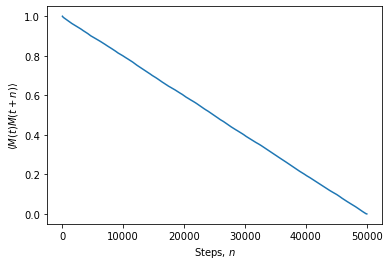

In [78]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

plt.plot(autocorr(M)/autocorr(M)[0] )
plt.xlabel('Steps, $n$')
plt.ylabel(r'$\langle M(t)M(t+n) \rangle$')

### Carry out explorative simulations

$\bf{i.}$ Test the dependence of observables on system size.

$\bf{ii.}$ Test the dependence of observables on initital conditions.

$\bf{iii.}$ Vary intensive parameters, e.g temperature and field strength. Investigate changes in observables such as magnetization, energy, susceptibility, heat capacity.

$\bf{iv.}$ How do we know if simulation has done enough sampling? How do we assess covnergence and errors? 

$\bf{v.}$ Think about alternative ways of accelerating and enhancing the sampling.

#### Parameter sweeps and calculation of second order thermodynamic quantities

In [97]:
def get_Cv(E, T):
    return np.var(E)/T**2

def get_Xi(M, T):
    return np.var(M)/T

In [109]:
# Carry out multiple MC runs at differnet Temperatures. 
# This calculation may take ~5 mins. 
# Think about equilibration, convergence and statistical errors

Ts = np.linspace(1, 4, 40) 
n_equil  = 100000
out = 10

Es, Ms, Cs, Xs = [], [], [], []  

for T in Ts:
    
    S, E, M = run_ising2d(spins=np.random.choice([-1, 1], size=(20, 20)), 
                          T=T, 
                          J=1, 
                          B=0, 
                          n_steps=int(2*n_equil), 
                          out_freq=out)
    
    E = E[n_equil//out:]
    M = M[n_equil//out:]
    
    Es.append(np.mean(E))
    Ms.append(np.mean(M))
    
    Cs.append(get_Cv(E, T)) 
    Xs.append(get_Xi(M, T))

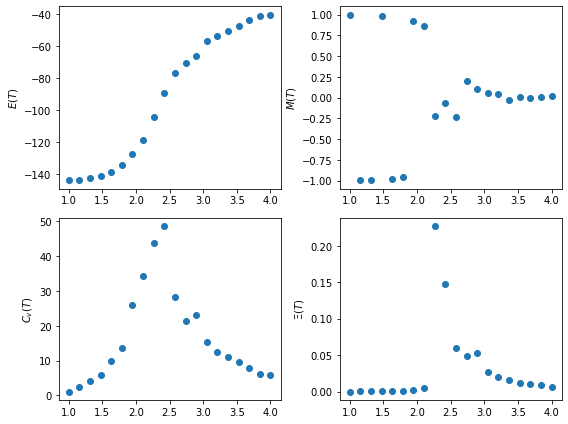

In [114]:
fig, ax  = plt.subplots(ncols=2, nrows=2, figsize=(8,6))

ax[0,0].scatter(Ts, Es)
ax[0,0].set(ylabel='$E(T)$')

ax[0,1].scatter(Ts, Ms)
ax[0,1].set(ylabel='$M(T)$')

ax[1,0].scatter(Ts, Cs)
ax[1,0].set(ylabel='$C_v(T)$')

ax[1,1].scatter(Ts, Xs)
ax[1,1].set(ylabel='$\Xi(T)$')
fig.tight_layout()

### Other Methods for sampling Ising models

**Wolf Algorithm (cluster methods):**

Near the critical point $T_c$ where the system develops a magnetization, any single-spin-flip dynamics becomes very slow (the correlation time diverges).
Wolff came up with a clever method to flip whole clusters of spins!

1. Pick a spin at random, remember its direction $D = \pm 1$, and flip it.
2. For each of the four neighboring spins, if it is
in the direction D, flip it with probability p.
3. For each of the new flipped spins, recursively
flip their neighbors as in (2).

**Gibbs Sampling:**

Gibbs sampling is conceptually even simpler than Metropolis algorithm and is based on the idea of sampling from conditional probabilities $p(x_1 | All\, x \neq\,\, x_1)$. Gibbs sampling is not as efficient as Wolff or Metropolis at but shines in other problems

In [ ]:
def WolffMove(lattice):
        """
        Pick a random spin; remember its direction as oldSpin
        Push it onto a list "toFlip" of spins to flip
        Set spinsFlipped = 0
        While there are spins left in toFlip Remove the first spin
           If it has not been flipped in between
              Flip it
              Add one to spinsFlipped
              For each of its neighbors
                  if the neighbor is in the oldSpin direction flip with probability p, put it on the stack
        Return spinsFlipped
        """
        i, j = np.random.randint(0, N), np.random.randint(0, N)

        oldSpin = lattice[i, j]
        toFlip = [(i, j)]
        
        spinsFlipped = 0
        while len(toFlip) > 0:
            
            i, j = toFlip.pop(0)
            
            # Check if flipped in between
            if lattice[i, j] == oldSpin:
                lattice[i, j] = (lattice[i, j] + 1) % 2
                spinsFlipped += 1

                neighbors = [((i+1)%N, j), ((i-1)%N, j), (i, (i+1)%N), (i, (i-1)%N)]
                for m, n in neighbors:
                    if  lattice[m, n] == oldSpin:
                        if np.random.random() < p:
                            toFlip.append((m, n))
        return spinsFlipped

def SweepWolff(nTimes=1, partialSweep=0):
        """
        Do sweeps until at least
        N*N-partialSweep spins have been flipped.
        """
        for time in range(nTimes):
            
            while partialSweep < N * N:
                partialSweep += WolffMove()
            partialSweep = partialSweep - (N*N)
        return partialSweep

### Problems

#### Problem-1

Revisit the example MCMC simulation for determining $\pi$ value. Vary the size of the displacement to determine the optimal size that generates quickest convergence to the value of $\pi$


#### Problem-2 

Carry out MC simulation of 2D ising spin model for various lattice sizes $N= 16,32, 64$ at temperatures above and below critical e.g $T<T_c$ and $T>T_c$.   

- How long does it take to equilibrate system as a function of size and as a function of T?

- Plot some observables as a function of number of samples states to show that the system is carrying out some sort of random walk in the configurational space. 

- How do profiles of Energy vs T, Magnetization vs T and heat capacity vs T, and susceptibility vs T change as a function of size of our lattice. 

- Does $J>0$ and $J<0$ change the nature of phase transition?

#### Problem-3

Compute correlation functions of spin variable, that is how correlated are spins as a function of distance on a lattice, $L$. $C(L)=\langle s_i s_{i+L}\rangle -\langle s_i\rangle \langle s_{i+L}\rangle $ Make sure to account for the periodic boundary conditions! 

> Note that you can pick a special tagged spin and calculate correlation function of taged spin ($s_13$ for instance) with any other as a function of lattice spearation  by averaging over produced MC configurations.  Or you can take advantage of the fact that there are no priviledged spins and average over many spins and average over MC configruations e.g $s_1, s_2, ...$. E.g you can pick a horizontal line of spins and run a summation for each fixed r_ab distance. 

#### Problem-4

Take a 20 by 20 lattice and equilibriate the system with a value of extneral field B equal to +1. 
Now slowly change h to −1 in discrete steps during each of these steps, use the previously equilibriated
configuration as an input to the system to undergo equilibriation again.  

Caluclate average and variance quantities (e.g E, M, C etc). Notice anything interesing :)